# Vizualise relationships between word embeddings

Ici, le but est de voir si les embeddings de BERT/NetBERT contiennent aussi certains attributs qui, quand soustraits ou additionnés, permettent d'arriver à une autre entité. Typiquement, le but est de voir si le fameux exemple du man:woman::king:queen marche aussi avec BERT dans un premier temps. dans un second temps, je m'intéresse à ce genre de relations entre entités mais dans le domaine du computer network, et regarde quel modèle (BERT/NetBERT) est le mieux adapté pour tel ou tel domaine.

In [25]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize, ha="center", va="center")
        return [tx]
Legend.update_default_handler_map({str : TextHandlerB()})

## 1. Implementation

In [33]:
def encode_words(model_name_or_path, sentences):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in indexed_tokens]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(indexed_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, sum the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, sentences, words_of_interest, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    embeddings = []
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if words_of_interest[i] in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            word_embedding = df.loc[(df['Sentence']==sent) & (df['Token']==words_of_interest[i]), ~df.columns.isin(['Token','Sentence'])].values[0]
            embeddings.append(word_embedding)

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(words_of_interest[i])
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
       
    return np.array(embeddings)


def perform_pca(word_embeddings, words_of_interest):
    """
    """
    pca = PCA(n_components=2, random_state=2)
    pca_result = pca.fit_transform(word_embeddings)

    pca_df = pd.DataFrame()
    pca_df['word'] = words_of_interest
    pca_df['pca-one'] = pca_result[:,0]
    pca_df['pca-two'] = pca_result[:,1]
    print(' - Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    return pca_df


def plot_relationships(pca_df, relationships, ax, title, limits=[(None, None), (None,None)]):
    """
    """
    # Scatterplot.
    ax.scatter(x = pca_df['pca-one'].values, y = pca_df['pca-two'].values)
    ax.set_xlabel('pca-1', fontsize=20, labelpad=10)
    ax.set_ylabel('pca-2', fontsize=20, labelpad=10)
    ax.set_title(title, fontsize=28, y=-0.2)
    ax.set_xlim(limits[0][0], limits[0][1])
    ax.set_ylim(limits[1][0], limits[1][1])
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    for line in pca_df.index:
        ax.text(pca_df.loc[line,"pca-one"]+0.2, 
                 pca_df.loc[line,"pca-two"]+0.2, 
                 pca_df.loc[line,"word"], 
                 horizontalalignment='left', 
                 size=20, 
                 color='gray',
                 weight='semibold')
    
    # Draw arrows between entities in relationships.
    for rel in relationships:
        entity_a = pca_df.loc[pca_df['word']==rel[0], pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
        entity_b = pca_df.loc[pca_df['word']==rel[1], pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
        ax.arrow(entity_a[0], entity_a[1],
                 entity_b[0]-entity_a[0], entity_b[1]-entity_a[1],
                 head_width=1, head_length=1,
                 fc='lightblue', ec='lightblue',
                 length_includes_head=True)
    return


def create_bold_labels(sentences, words_of_interest):
    """
    """
    labels = []
    for i, sent in enumerate(sentences):
        labels.append(sent.replace(words_of_interest[i], r"$\bf{" + "{}".format(words_of_interest[i]) + "}$"))
    return labels


def run_all(sentences, words_of_interest, relationships, fig_name):
    """
    """
    #--------------
    # Encode words
    #--------------
    print("BERT-base")
    bert_df = encode_words('bert-base-cased', sentences)
    print("NetBERT")
    netbert_df = encode_words('../_models/netbert-final/', sentences)


    #---------------------
    # Get word embeddings
    #---------------------
    bert_embeddings = get_embeddings(bert_df, sentences, words_of_interest, 'bert-base-cased')
    netbert_embeddings = get_embeddings(netbert_df, sentences, words_of_interest, '../_models/netbert-final/')
    
    #---------------------
    # Perform PCA
    #---------------------
    bert_pca_df = perform_pca(bert_embeddings, words_of_interest)
    netbert_pca_df = perform_pca(netbert_embeddings, words_of_interest)
    
    
    #-------------------
    # Plot relationships
    #-------------------
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    
    # Get x and yaxis limits depending on min and max values.
    tmp_df = pd.concat([bert_pca_df, netbert_pca_df], ignore_index=True)
    limits = [(tmp_df['pca-one'].min()-5, tmp_df['pca-one'].max()+5), (tmp_df['pca-two'].min()-5, tmp_df['pca-two'].max()+5)]
    
    # Create plots.
    plot_relationships(bert_pca_df, relationships, ax1, '(a) BERT embeddings.', limits)
    plot_relationships(netbert_pca_df, relationships, ax2, '(b) NetBERT embeddings.', limits)
    
    # Create legend.
    labels = create_bold_labels(sentences, words_of_interest)
    handles = ['-'] * len(labels)
    legend = fig.legend(handles=handles, labels=labels, title='Contexts', fontsize='18', loc='upper center', bbox_to_anchor=(0.42, 1.17))
    legend.get_title().set_fontsize('22')
    legend._legend_box.align = "left"
    
    # Save figure.
    fig.savefig("./figures/word_analogy_"+ fig_name +".pdf", bbox_inches='tight')
    return

## 2. Tests

### "man:woman :: king:queen"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 11 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 11 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.6701923  0.25985447]
 - Explained variation per principal component: [0.428839   0.33733708]


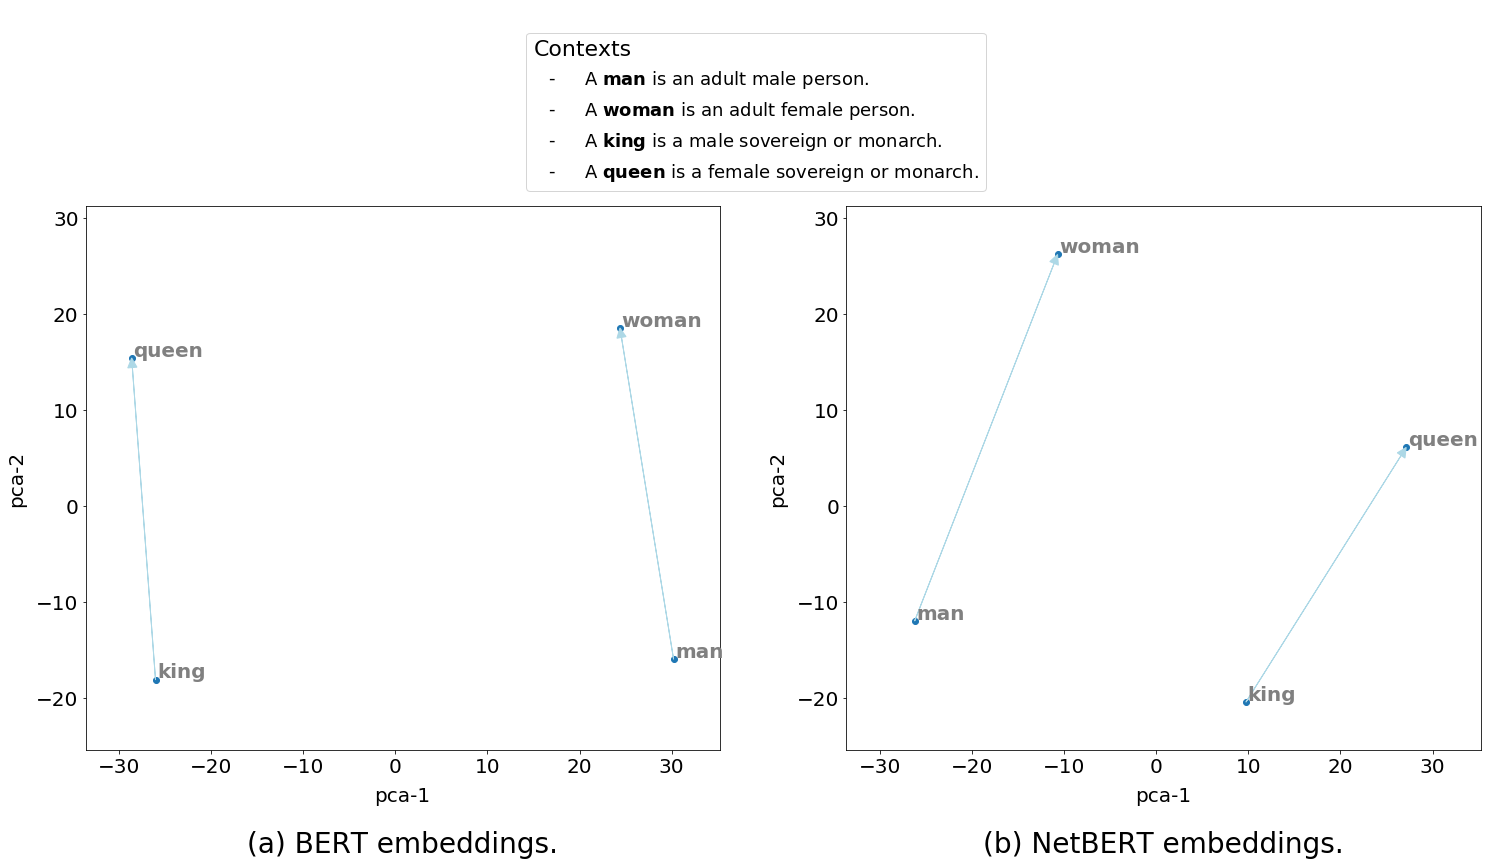

In [34]:
sentences = ["A man is an adult male person.",
             "A woman is an adult female person.",
             "A king is a male sovereign or monarch.",
             "A queen is a female sovereign or monarch."]
words_of_interest = ['man', 'woman',
                     'king', 'queen']
relationships = [('man','woman'),
                 ('king','queen')]
run_all(sentences, words_of_interest, relationships, fig_name="man_woman")

### "switch:STP :: router:BGP"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 17 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 17 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.58132017 0.22863668]
 - Explained variation per principal component: [0.46780688 0.2904794 ]


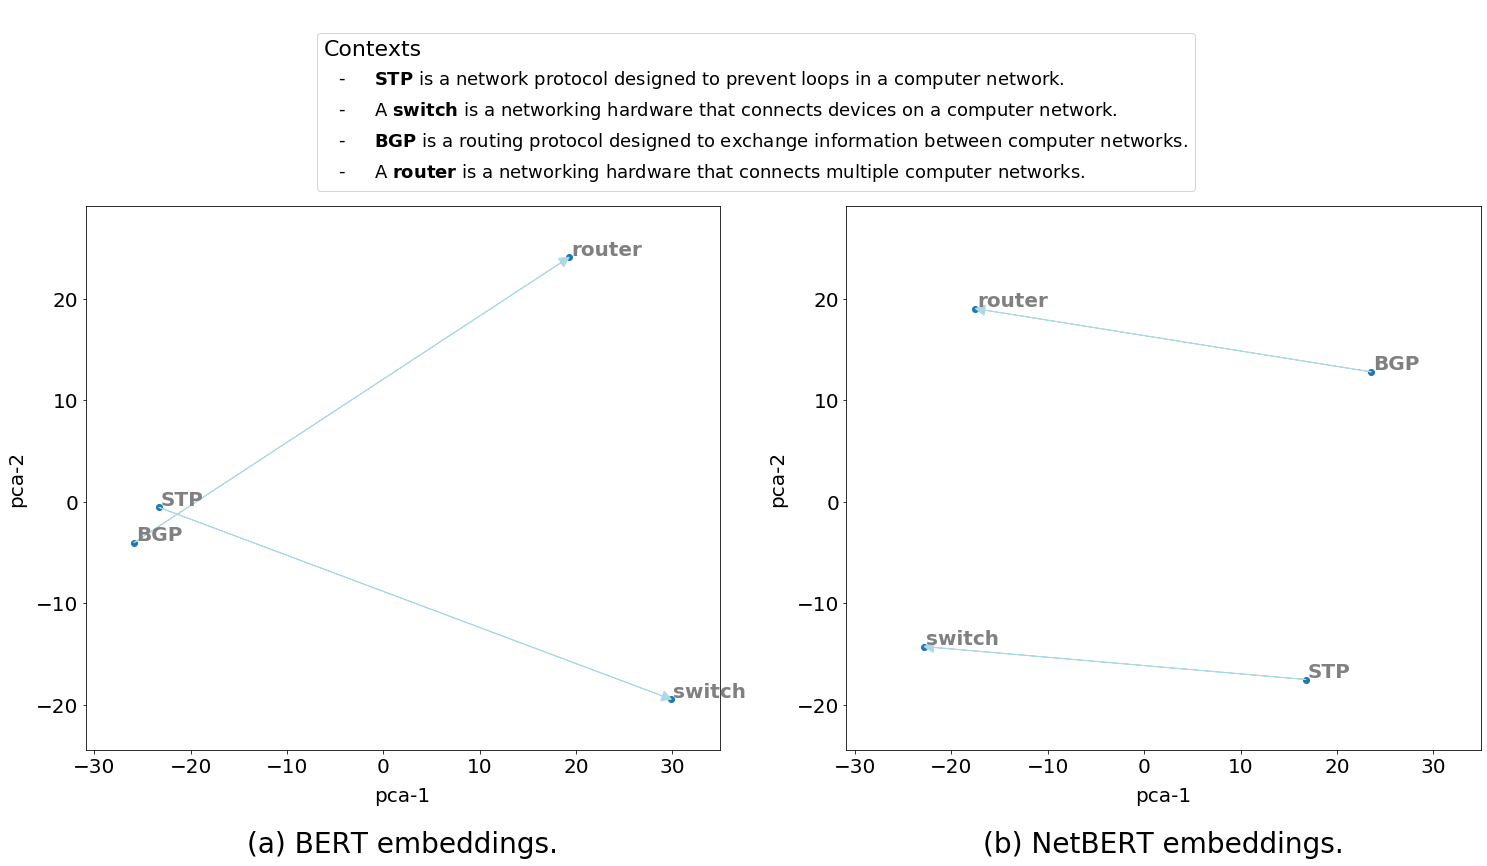

In [39]:
sentences = ["STP is a network protocol designed to prevent loops in a computer network.",
             "A switch is a networking hardware that connects devices on a computer network.",
             "BGP is a routing protocol designed to exchange information between computer networks.",
             "A router is a networking hardware that connects multiple computer networks."]
words_of_interest = ['STP', 'switch', 'BGP', 'router']
relationships = [('STP', 'switch'),('BGP', 'router')]
run_all(sentences, words_of_interest, relationships, fig_name="stp_bgp")

### "mac(address):switch :: ip(address):router"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.5095127  0.28646132]
 - Explained variation per principal component: [0.50047964 0.25920027]


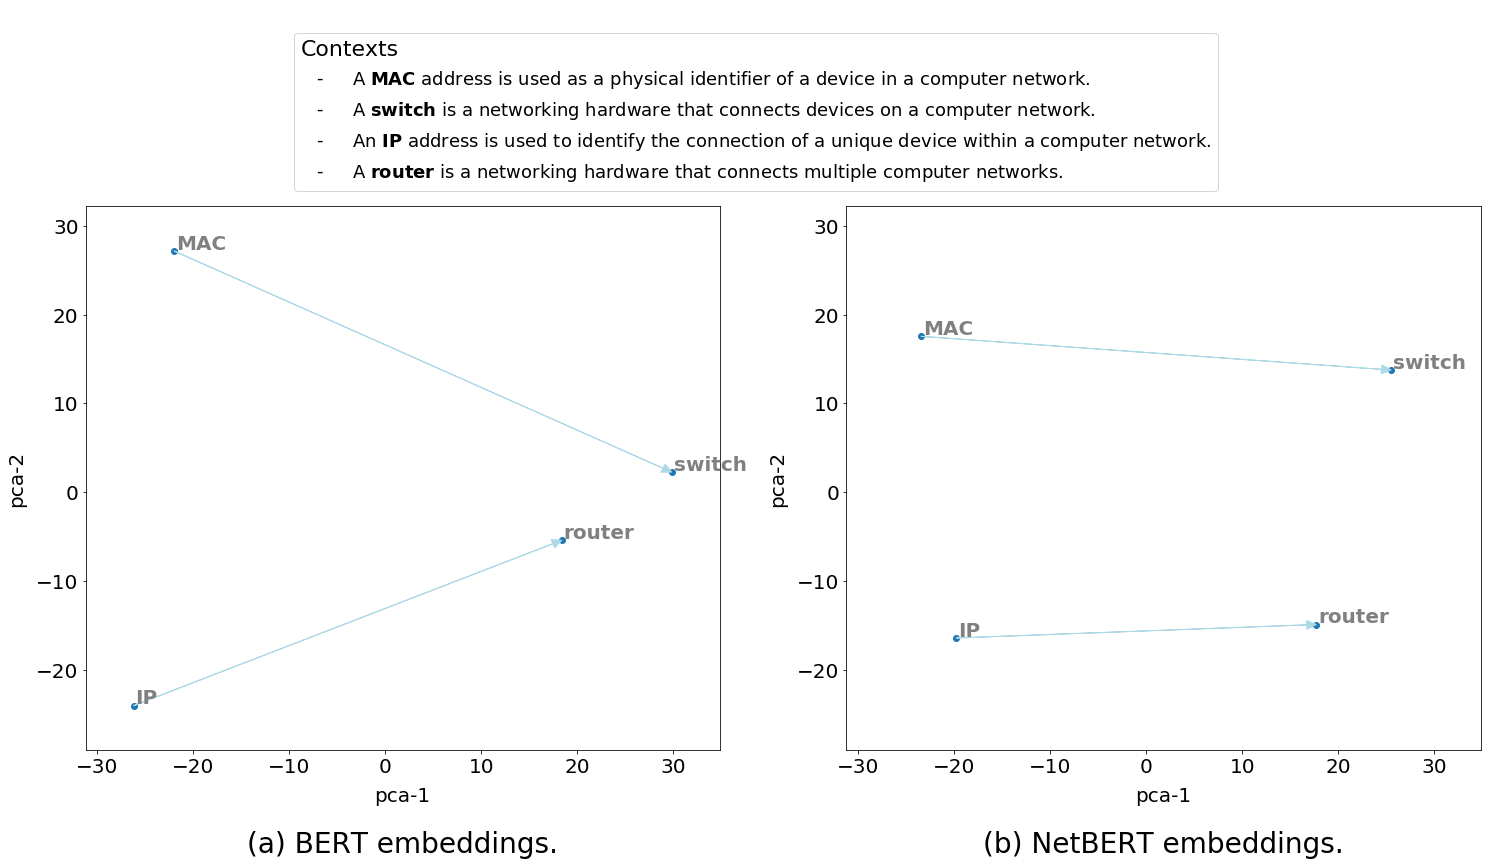

In [36]:
sentences = ["A MAC address is used as a physical identifier of a device in a computer network.",
             "A switch is a networking hardware that connects devices on a computer network.",
             "An IP address is used to identify the connection of a unique device within a computer network.",
             "A router is a networking hardware that connects multiple computer networks."]
words_of_interest = ['MAC', 'switch', 'IP', 'router']
relationships = [('MAC', 'switch'),('IP', 'router')]
run_all(sentences, words_of_interest, relationships, fig_name="mac_ip")

### "tcp:transport(layer) :: ip:network(layer)"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 25 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 25 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.53820986 0.27011004]
 - Explained variation per principal component: [0.4879393 0.3056255]


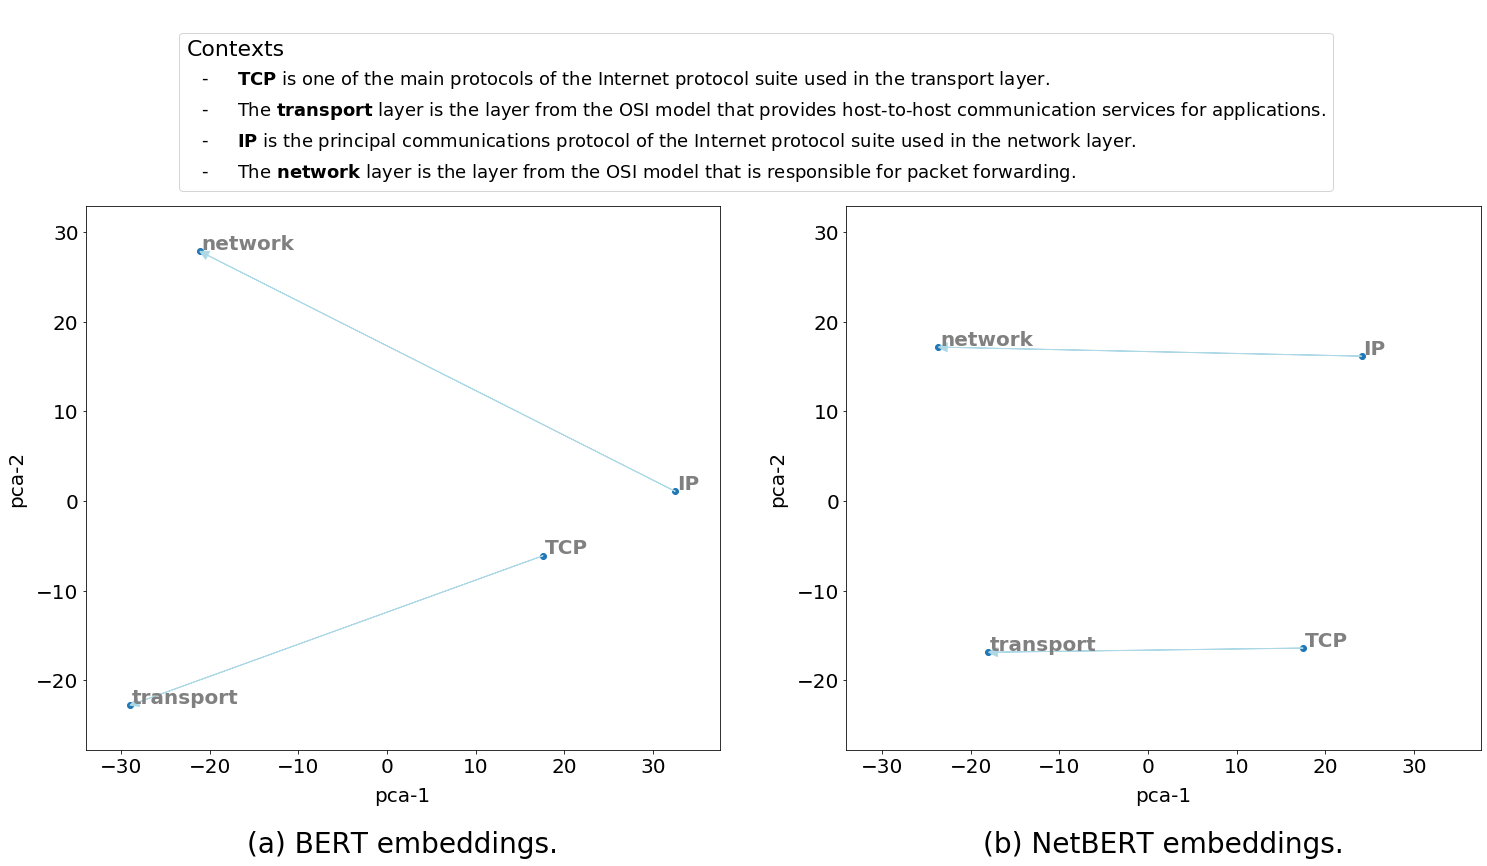

In [37]:
sentences = ["TCP is one of the main protocols of the Internet protocol suite used in the transport layer.",
             "The transport layer is the layer from the OSI model that provides host-to-host communication services for applications.",
             "IP is the principal communications protocol of the Internet protocol suite used in the network layer.",
             "The network layer is the layer from the OSI model that is responsible for packet forwarding." 
]
words_of_interest = ['TCP', 'transport', 'IP', 'network']
relationships = [('TCP', 'transport'),('IP', 'network')]
run_all(sentences, words_of_interest, relationships, fig_name="tcp_ip")

### "lsa:ospf :: lsp:isis"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 15 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 15 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.4888029 0.3565427]
 - Explained variation per principal component: [0.628858   0.27271116]


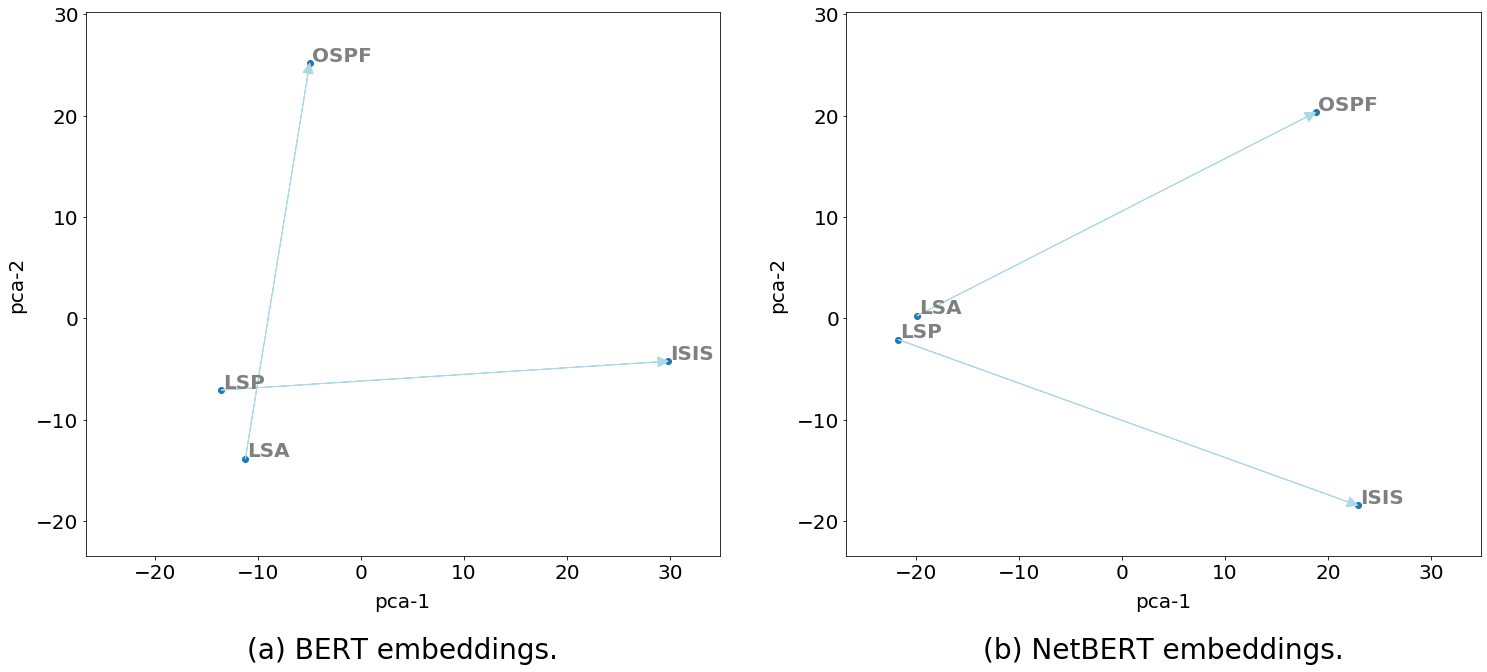

In [5]:
sentences = ["LSA is a communication in the OSPF routing protocol.",
             "OSPF is a routing protocol for IP networks.",
             "LSP is a communication mean in the ISIS routing protocol.",
             "ISIS is a routing protocol for IP networks."
]
words_of_interest = ['LSA', 'OSPF', 'LSP', 'ISIS']
relationships = [('LSA', 'OSPF'),('LSP', 'ISIS')]
run_all(sentences, words_of_interest, relationships, fig_name="lsa_lsp")

### "ttl:ipv4 :: hoplimit:ipv6"

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 20 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 20 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.6448964  0.32193246]
 - Explained variation per principal component: [0.70443827 0.22845434]


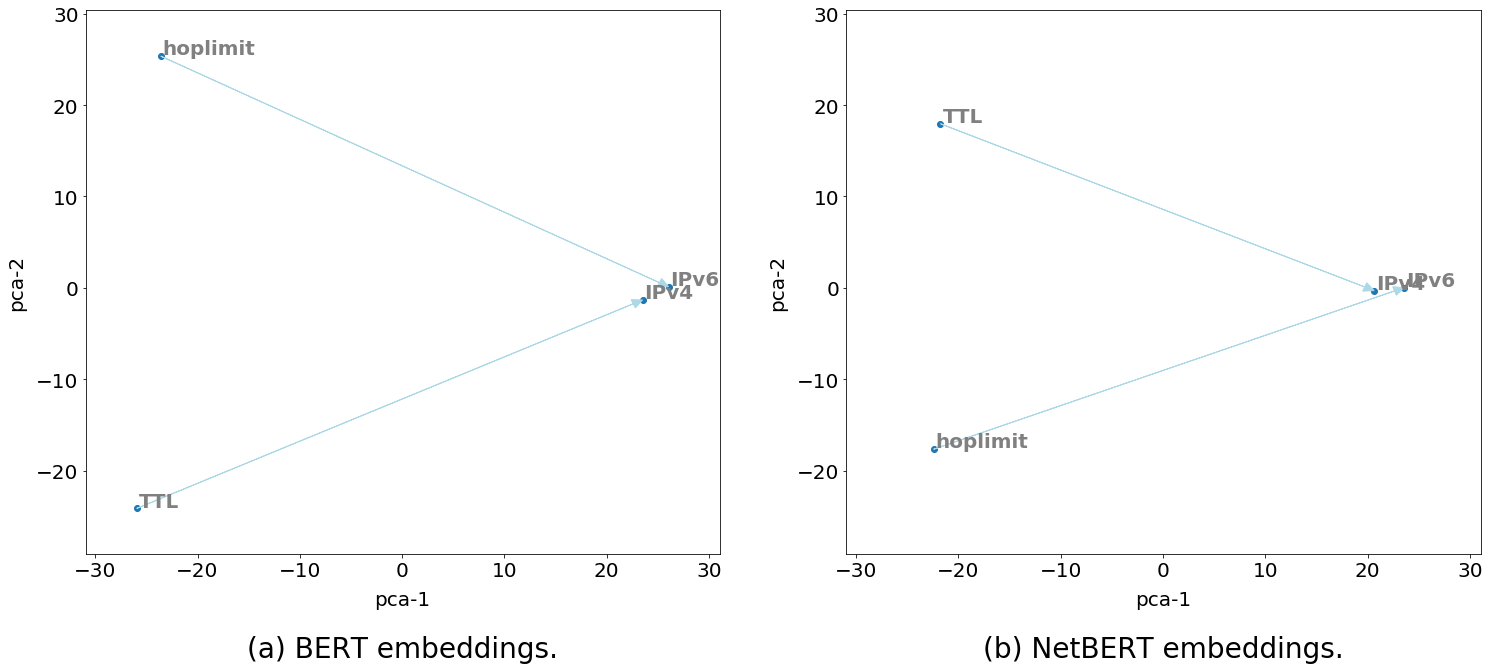

In [11]:
sentences = ["The TTL is a mechanism that limits the lifetime of data under IPv4.",
             "The IPv4 is the fourth version of the Internet Protocol.",
             "The hoplimit is a mechanism that limits the lifetime of data under IPv6.",
             "The IPv6 is the sixth version of the Internet Protocol."
]
words_of_interest = ['TTL', 'IPv4', 'hoplimit', 'IPv6']
relationships = [('TTL', 'IPv4'),('hoplimit', 'IPv6')]
run_all(sentences, words_of_interest, relationships, fig_name="ttl_hoplimit")

### Contre-example ("ethernet:internet :: ")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 12 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 12 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
 - Explained variation per principal component: [0.66330224 0.23529792]
 - Explained variation per principal component: [0.5171655  0.37222087]


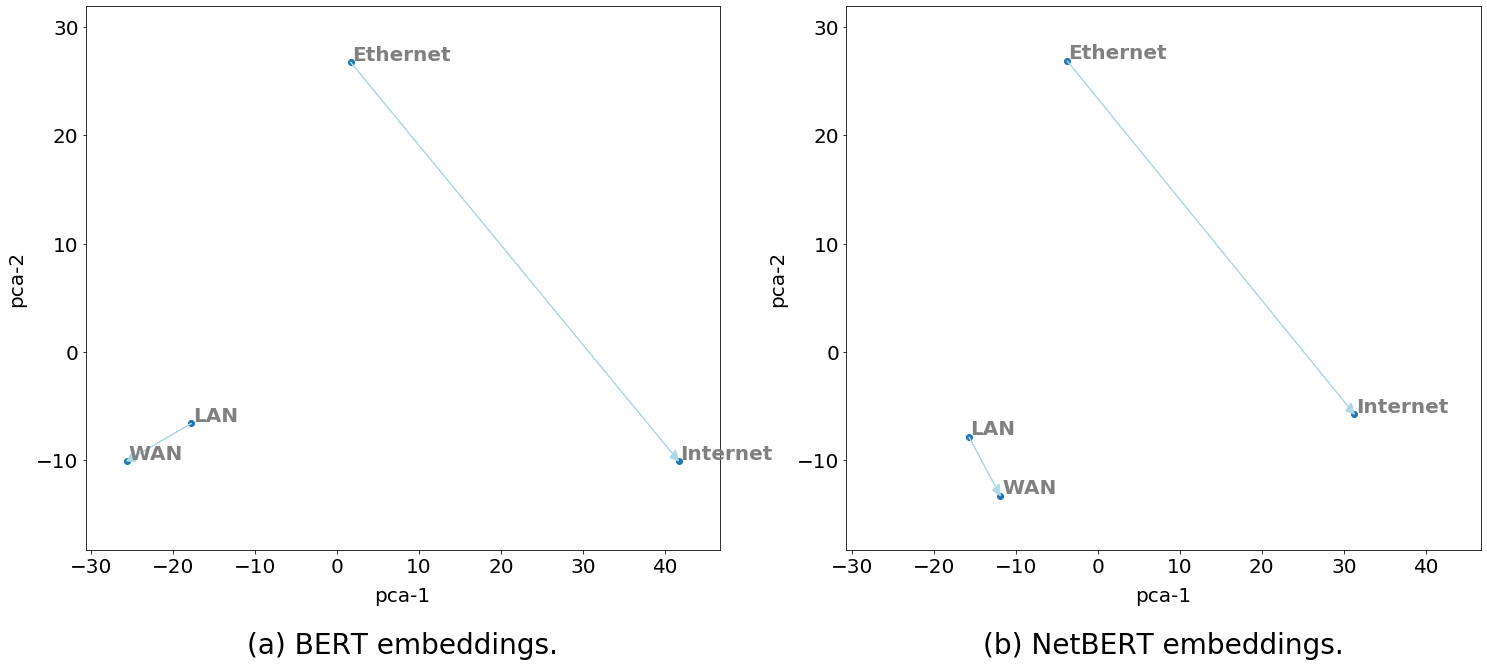

In [13]:
sentences = ["Ethernet is a computer network technology.",
             "Internet is a computer networking technology.",
             "A LAN is a type of computer network.",
             "A WAN is a type of computer network."]
words_of_interest = ['Ethernet', 'Internet', 'LAN', 'WAN']
relationships = [('Ethernet', 'Internet'),('LAN', 'WAN')]
run_all(sentences, words_of_interest, relationships, fig_name="lan_wan")